In [2]:
#import relevant libraries
import os
from scipy import stats

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm
import seaborn as sns
import dabest
import NLCLIMB
import NLMATH
import itertools
from datetime import datetime
date = datetime.today().strftime('%Y%m%d')
from statistics import mean
from textwrap import wrap

#import dabest_2023
import dabest
#import dabest_jck
import plotly.express as px 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from plotly.graph_objects import Layout
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import osar 

#NOTE: SUPPRESSES WARNINGS!

import warnings


warnings.simplefilter(action="ignore", category=RuntimeWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

print(osar.__version__)

0.23.7


In [47]:
basegenotype = "SS95118"
responder = "Chrimson2"
wt = "w1118"
addNotes = basegenotype + " x " + responder
transgenic = addNotes

officecomp = "C:\\Users\\Star\\"
labcomp = "C:\\Users\\User\\"
computer2 = "C:\\Users\\lnico"
computer3 = "D:"

filedirectory_OSAR = "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\DATA\\OSAR\\"
filedirectory_Falling = "ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\Data Compilation\\Falling_New\\"
specifiedpath = officecomp

baseDirectory_OSAR = specifiedpath + filedirectory_OSAR + addNotes
baseDirectory_Falling = specifiedpath + filedirectory_Falling + addNotes

#OSAR related files
if len(addNotes) > 0:
    addNotes = "_" + addNotes   
filename_O = baseDirectory_OSAR + "\\" + basegenotype
filename_AppendDT = "_gen " + date

filename_O = filename_O + addNotes + filename_AppendDT


#Falling related files
filename_F = baseDirectory_Falling + ".csv"
filenamewt_F = specifiedpath + filedirectory_Falling + wt+"_"+ transgenic + ".csv"


filename_O

'C:\\Users\\Star\\ACC Lab Dropbox\\ACC Lab\\Nicole Lee\\DATA\\OSAR\\SS95118 x Chrimson2\\SS95118_SS95118 x Chrimson2_gen 20250114'

## OSAR

In [28]:
def singleplottingdabest(dfi, names, parameter):
    dfrr = pd.DataFrame()
    filter1 = dfi[(dfi['status'] == 'Offspring')].copy().reset_index(drop=True)
    filter2 = dfi[(dfi['status'] == 'Sibling')].copy().reset_index(drop=True)

    dfrr[names + " Cntrl" ] = filter2[parameter]
    dfrr[names] = filter1[parameter]
    #dfr1 = pd.concat([dfr1, dfrr], axis = 1)
        
    l = dfrr.columns.tolist()
    titlelst = list(zip(l,l[1:]))[::2]  
    test = dabest.load(dfrr, idx=titlelst, ci=90)    
    
    return test

In [5]:
#check for border shift
osarAnalysis = osar.osar(baseDirectory_OSAR,
                        # border_shift_mm = 1.5,  
                        # countlog_folder = "countlog_Full Only",         
                        # countlog_folder = "countlog_Half and Full",
                         driver = basegenotype)

Creating borders for each fly...
Done.

Processing CSV 40 of 40
Summarising results for all flies...
All done.


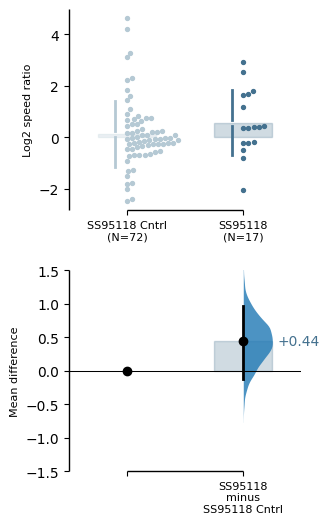

In [ ]:
full_light = osarAnalysis.results[osarAnalysis.results['light_intensity'] == "Full"]
singleplottingdabest(full_light, basegenotype,'log2_speed_ratio_Pattern 01').mean_diff.plot(float_contrast=False, fontsize_rawylabel=8, fontsize_rawxlabel=8, 
                                                                      fontsize_contrastxlabel=8, fontsize_contrastylabel=8, raw_marker_size=2, es_marker_size=6, 
                                                                      custom_palette="Paired", swarm_label="Log2 speed ratio", contrast_ylim=(-1.5,1.5));

In [64]:
speed_osar = float(singleplottingdabest(full_light, basegenotype,'log2_speed_ratio_Pattern 01').mean_diff.statistical_tests['difference'])
speed_osar

0.4373069087457313

## Falling

In [108]:
def full_lightreplace(df, basegenotype):
    df = df.replace("Full", "Light")
    #df['genre']= df['genre'].replace("Full", "Light")
    df['Type'] = df['Type'].replace("Expt", basegenotype) 

    return df

In [89]:
dfe=pd.read_csv(filename_F)
dfw= pd.read_csv(filenamewt_F)

exptdf = dfe.drop(dfe.columns[[0]],axis = 1)
wtdf = dfw.drop(dfw.columns[[0]],axis = 1)

dfexpt = NLCLIMB.generation(exptdf, basegenotype)
dfwt = NLCLIMB.generation(wtdf, wt)

In [126]:
df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)
df_sp1 = full_lightreplace(df_sp.copy(), basegenotype)
df_bsp = NLMATH.bspeed(NLMATH.boutspeed(dfexpt), NLMATH.boutspeed(dfwt)).reset_index(drop=True)
df_bsp1 = full_lightreplace(df_bsp.copy(), basegenotype)

dftotal = pd.DataFrame()

dfs2 = NLMATH.deltaversion(df_sp, basegenotype, "Velocity")
dfs2['Genre'] = "Speed"

dfbs2 = NLMATH.deltaversion(df_bsp, basegenotype, "BSpeed")
dfbs2['Genre'] = "Bout_speed"

dftotal_falling = pd.concat([dfs2, dfbs2], axis = 0).reset_index(drop=True)
dftotal_falling['Assay'] = "Falling"

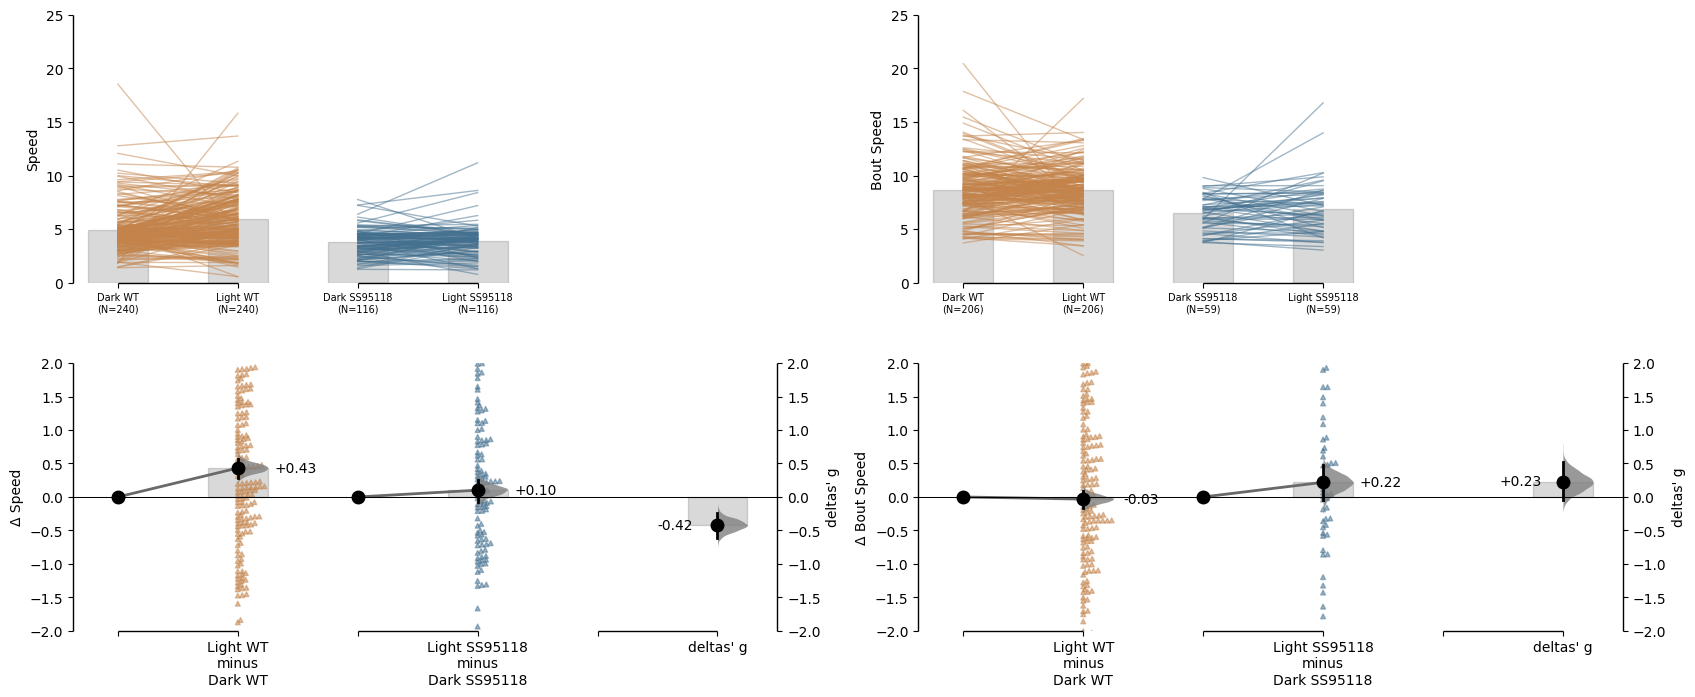

In [124]:
figfirstplot, axs = plt.subplots(1,2, figsize=(20, 8),sharex = "col")

speedplots = dabest.load(data=df_sp1, x=["ExperimentState","Type"], y="Velocity", delta2 = True, experiment="Type", 
                             experiment_label = ["WT", basegenotype], x1_level = ["Dark","Light"], paired = "baseline", id_col = "index")
speedplots.delta_g.plot(swarm_label="Speed",
                                    contrast_label="Δ Speed", swarm_ylim = (0,25),  contrast_ylim=(-2, 2),fontsize_rawxlabel=7, fontsize_rawylabel=10, fontsize_contrastxlabel=10, 
                                    fontsize_contrastylabel=10, fontsize_delta2label=10,
                                    ax=axs.flat[0]);

boutspeed_plots = dabest.load(data=df_bsp1, x=["ExperimentState","Type"], y="BSpeed", delta2 = True, experiment="Type", 
                             experiment_label = ["WT", basegenotype], x1_level = ["Dark","Light"], paired = "baseline", id_col = "index")
boutspeed_plots.delta_g.plot(swarm_label="Bout Speed",
                                    contrast_label="Δ Bout Speed", swarm_ylim = (0,25),  contrast_ylim=(-2, 2),fontsize_rawxlabel=7, fontsize_rawylabel=10, fontsize_contrastxlabel=10, 
                                    fontsize_contrastylabel=10, fontsize_delta2label=10,
                                    ax=axs.flat[1]);

# Total

## Direct comparison (Falling delta g and OSAR delta)

In [143]:
df_directcomp = pd.DataFrame()

df_directcomp['osar_speed'] = [speed_osar]
df_directcomp['falling_speed'] = dftotal_falling[dftotal_falling['Genre'] == "Speed"]["delta_g"].reset_index(drop=True)
df_directcomp['falling_boutspeed'] = dftotal_falling[dftotal_falling['Genre'] == "Bout_speed"]["delta_g"].reset_index(drop=True)
df_directcomp['MBON'] = basegenotype


df_directcomp

,osar_speed,falling_speed,falling_boutspeed,MBON
0,0.437307,-0.421,0.135,SS95118


## Falling to Log speed ratio

In [180]:
## will look at overall speed/fly in light - overall speed/fly in darkimport math
import math

df_sp = NLMATH.ospeed(dfwt, dfexpt).reset_index(drop=True)

df_srfalling = pd.DataFrame()

for n in df_sp['index'].unique().tolist():
    df_temp = pd.DataFrame()
    sectioned = df_sp[df_sp['index']==n]
    darkvalue = float(sectioned[sectioned["ExperimentState"] == "Dark"]['Velocity'])
    lightvalue = float(sectioned[sectioned["ExperimentState"] == "Full"]['Velocity'])
    speedratio = math.log2(lightvalue/darkvalue)
    df_temp["Name"] = [n]
    df_temp["Speedratio"] = [speedratio]
    df_temp["Type"] = sectioned["Type"].unique().tolist()
    df_srfalling = pd.concat([df_srfalling, df_temp])

df_srfalling = df_srfalling.replace("Expt", basegenotype)

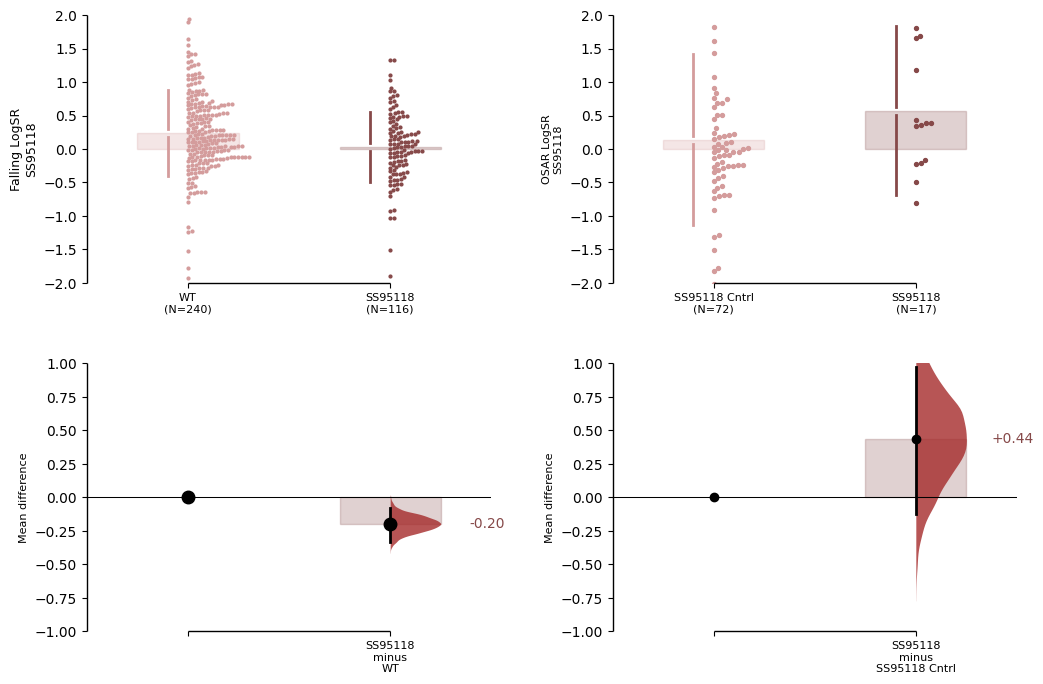

In [ ]:
figsecondplot, axs1 = plt.subplots(1,2, figsize=(12, 8),sharex = "col", gridspec_kw={'wspace': 0.3})

fallingtosarplots = dabest.load(df_srfalling, idx = ("WT", basegenotype), x= "Type", y = "Speedratio")
fallingtosarplots.mean_diff.plot(float_contrast=False, raw_marker_size=1, swarm_ylim = (-2,2), contrast_ylim=(-1, 1), fontsize_rawxlabel=8, fontsize_rawylabel=9, fontsize_contrastxlabel=8, 
                                    fontsize_contrastylabel=8, custom_palette={"WT" : 'lightcoral', basegenotype :'brown'}, swarm_label="Falling LogSR\n" + basegenotype, ax=axs1.flat[0]);

singleplottingdabest(full_light, basegenotype,'log2_speed_ratio_Pattern 01').mean_diff.plot(float_contrast=False, fontsize_rawylabel=8, fontsize_rawxlabel=8, swarm_ylim = (-2,2), contrast_ylim=(-1, 1),
                                                                      fontsize_contrastxlabel=8, fontsize_contrastylabel=8, raw_marker_size=2, es_marker_size=6, 
                                                                      custom_palette={basegenotype + " Cntrl" : 'lightcoral', basegenotype :'brown'}, swarm_label="OSAR LogSR\n" + basegenotype, ax=axs1.flat[1]);

## OSAR to Falling Speed

In [224]:
full_light.columns

Index(['exptDate', 'driver', 'expt_time_start', 'genotype', 'opsin',
       'light_intensity', 'light_color', 'status',
       'reversals_to_light_BASELINE', 'traversals_to_light_BASELINE',
       'reversals_to_dark_BASELINE', 'traversals_to_dark_BASELINE',
       'light_attraction_index_BASELINE', 'pi_smoothed_BASELINE',
       'log2_speed_ratio_BASELINE', 'distance_in_light_BASELINE',
       'time_in_light_BASELINE', 'distance_in_dark_BASELINE',
       'time_in_dark_BASELINE', 'time_in_choice_zone_BASELINE',
       'speed_before_cross_to_dark_BASELINE',
       'speed_after_cross_to_dark_BASELINE',
       'speed_before_cross_to_light_BASELINE',
       'speed_after_cross_to_light_BASELINE', 'reversals_to_light_Pattern 01',
       'traversals_to_light_Pattern 01', 'reversals_to_dark_Pattern 01',
       'traversals_to_dark_Pattern 01', 'light_attraction_index_Pattern 01',
       'pi_smoothed_Pattern 01', 'log2_speed_ratio_Pattern 01',
       'distance_in_light_Pattern 01', 'time_in_light